# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# Read in Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

dataset = pd.read_csv('/content/gdrive/MyDrive/SuperModels-Data-X/TS_ALL_V2.csv')

Mounted at /content/gdrive


# Add New Columns

We add a new column for 'Net Savings.' This is calculated as the difference between each month's income and each month's spending.

In [ ]:
# Add Net Savings Column
dataset['net_savings'] = abs(dataset['income']) - dataset['spending']
dataset['net_savings'] = dataset['net_savings'].astype('int')

SaverLife stores income and spending amounts in cents. For ease of interpretation, we converts all columns whose units are specified in cents to dollars.

In [ ]:
dataset['income'] = -dataset['income'] / 100
dataset['net_savings'] = dataset['net_savings'] / 100
dataset['spending'] = dataset['spending'] / 100
dataset['balance'] = dataset['balance'] / 100

We also create new categorical variables that specify year and month.

In [ ]:
# Add Year and Month Columns
dataset[['year', 'month']] = dataset['year_month'].str.split("_", expand=True)
dataset['year'] = dataset['year'].astype('int')
dataset['month'] = dataset['month'].astype('int')

Finally, we specify a dummy variable for a certain user sign-up method that SaverLife had of interest. Partner A is an application that people can use to check their available balance for Partner A. Partner A and SaverLife have worked together in the past, and a large subset of users have signed up for SaverLife through Partner A.

In [ ]:
# Add Binary Variable for Partner A Campaign (aka Partner A)
def ebt_yn(campaign):
    if campaign =='Partner A':
        return 1
    else:
        return 0
dataset['Partner A'] = dataset['campaign_name'].apply(ebt_yn)

# Sort Values By User, Date Ascending from Earliest to Most Recent

To calculate our lagged variables, our data must be sorted in a particular manner. Monthly observations must be sorted by User, and must be sorted by date ascending from earliest to most recent.

In [ ]:
dataset = dataset.sort_values(['user_id', 'year', 'month'], ascending = (True, True, True))
dataset.head()

# Removal of Outliers

As a team, we had many conversations with SaverLife on what to do with outliers. As a first pass, they explained that the most accurate accounts that they had seen were people's checking accounts. Data was less accurate in other accounts just as Paypal accounts. There are also often large spending and income amounts that appear to be outliers. We remove some extreme values that are beyond some factor lower than the first quartile and above the third quartile.

In [ ]:
# Remove Outliers for Lag Datatset
Q1 = dataset.quantile(q=0.25)
Q3 = dataset.quantile(q=0.75)
IQR = Q3 - Q1
dataset_remove_outliers = dataset[~((dataset < (Q1 - 7.5 * IQR)) | (dataset > (Q3 + 7.5 * IQR))).any(axis=1)]
dataset_remove_outliers.shape

(245498, 12)

# Linear Regression of Monthly Income versus Monthly Spending

We run a simple linear regression of spending on income to assess the relationship of these two variables among all of SaverLife's users.

In [ ]:
x = dataset_remove_outliers['income']
y = dataset_remove_outliers['spending']

## your code here 
E_x = np.mean(x)
E_y = np.mean(y)
cov_xy = np.mean(x*y)-E_x*E_y
y_0 = E_y - cov_xy/np.var(x)*E_x
m = cov_xy/np.var(x)
# print(m)
# print(y_0)

y_pred = m*x + y_0
train_error_a = np.mean(np.square(y_pred - y))

# Final Plot

We plot the results of our regression versus a scatter plot of all users' monthly savings versus income observations. **We notice here that users are spending almost all of their income each month, foreshadowing the difficulty it may be to predict long-term savings propensiy

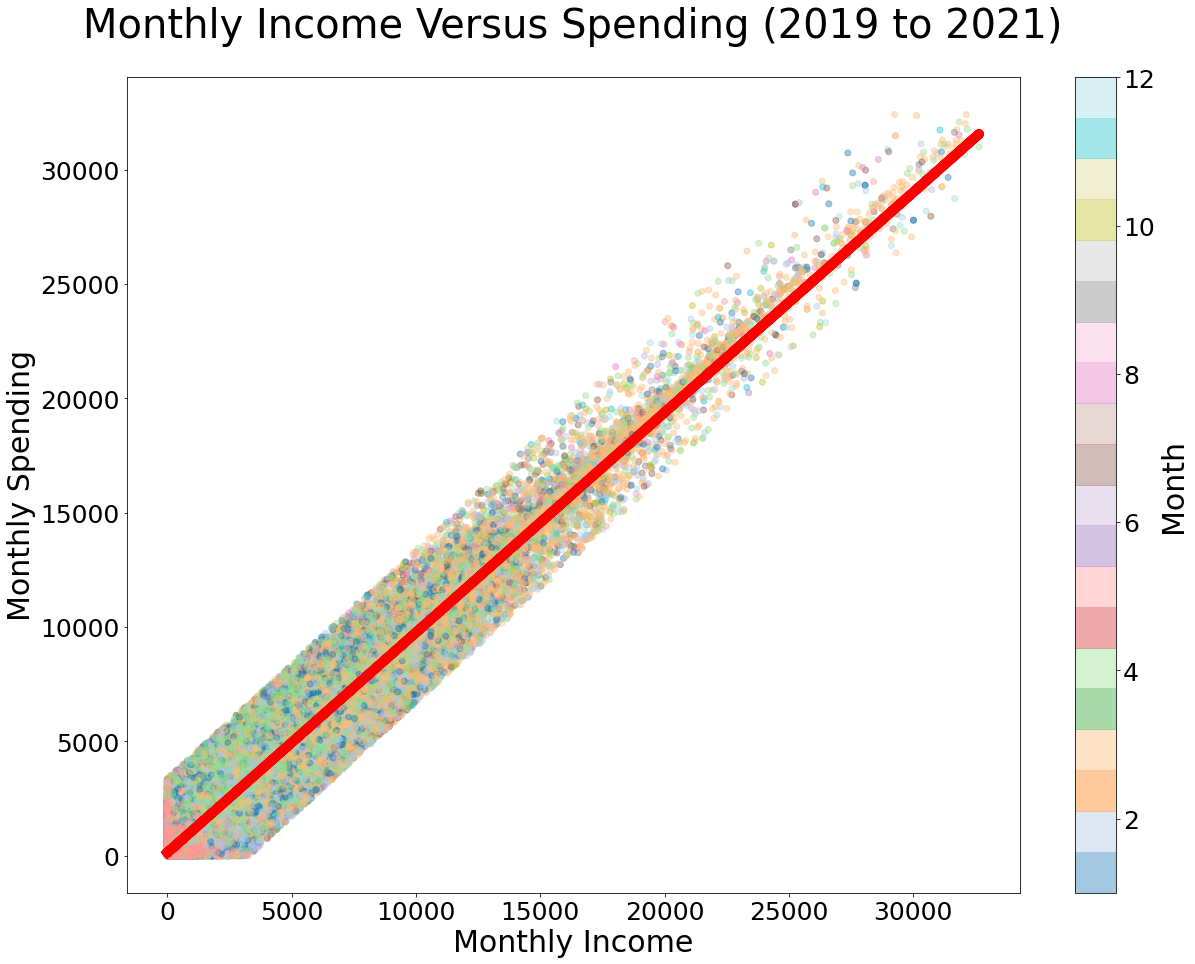

In [ ]:
# Plot Settings
plt.figure(figsize=(20, 15))
plt.rc('axes', titlesize=40)
plt.rc('axes', labelsize=30)
plt.rc('ytick', labelsize=25)
plt.rc('xtick', labelsize=25)

# Scatter Plot
plt.scatter(dataset_remove_outliers['income'], dataset_remove_outliers['spending'], 
            c=dataset_remove_outliers['month'],
            cmap='tab20',
            alpha=0.4)
plt.plot(x, y_pred, color='red', linewidth=10, dash_capstyle='round')
plt.xlabel('Monthly Income')
plt.ylabel('Monthly Spending')
plt.title('Monthly Income Versus Spending (2019 to 2021)', pad=40)
cbar = plt.colorbar()
cbar.set_label('Month')
plt.show()